In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/'

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

In [ ]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
import wfdb

In [ ]:
total_rpeaks

NameError: ignored

In [ ]:
# File extensions for data and annotations
dat_file_extension = 'dat'
atr_file_extension = 'atr'

heartbeats = []
labels = []

total_rpeaks = 0
total_heatbeats = 0
total_labels = 0

def clean_data(data):
    # Remove outliers
    data = np.clip(data, -10, 10)

    # Correct baseline wander
    data = data - np.mean(data)

    return data

def normalize_data(data):

    data = (data - np.min(data)) / (np.max(data) - np.min(data))

    return data

In [ ]:
for record_number in [100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
                      111, 112, 113, 114, 115, 116, 117, 118, 119,
                      121, 122, 123, 124,
                      200, 201, 202, 203, 205, 207, 208, 209, 210,
                      212, 213, 214, 215, 217, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]:

    record_name = str(record_number)

    try:
        # Load ECG data from the .dat file
        record = wfdb.rdrecord(os.path.join(data_path, record_name))
        ecg_data = record.p_signal[:, 0]

        # Load annotations from the .atr file
        annotation = wfdb.rdann(os.path.join(data_path, record_name), atr_file_extension)

        # Clean ECG data
        # Replace this with your clean_data function
        ecg_data = clean_data(ecg_data)

        # Normalize the ECG signal to the range [0, 1]
        # Replace this with your normalize_data function
        ecg_data = normalize_data(ecg_data)

        # Find R-peaks in the ECG signal
        r_peaks, _ = find_peaks(ecg_data, height=0.2, distance=200)

        for r_peak in r_peaks:
            total_rpeaks = total_rpeaks + 1
            # Determine the annotation label for the current R-peak
            annotation_indices = np.where(annotation.sample == r_peak)[0]

            if annotation_indices.size > 0:
                # Use the first matching annotation index
                annotation_index = annotation_indices[0]
                annotation_label = annotation.symbol[annotation_index]

            start = r_peak - 100  # Adjust the window size as needed
            end = r_peak + 100    # Adjust the window size as needed
            if start < 0 or end >= len(ecg_data):
                continue

            heartbeat_segment = ecg_data[start:end]
            heartbeats.append(heartbeat_segment)
            labels.append(annotation_label)

            total_heatbeats = total_heatbeats + 1
            total_labels = total_labels + 1

        aami_categories = {'N': [], 'S': [], 'V': [], 'F': [], 'Q': []}

        for i in range(len(heartbeats)):
            annotation_l = labels[i]
            heartbeat = heartbeats[i]

            if annotation_l in ['N', 'L', 'R', 'e', 'j']:
                aami_categories['N'].append(heartbeat)

            elif annotation_l in ['V', 'E']:
                aami_categories['V'].append(heartbeat)

            elif annotation_l in ['A', 'a', 'J', 'S']:
                aami_categories['S'].append(heartbeat)

            elif annotation_l == 'F':
                aami_categories['F'].append(heartbeat)

            elif annotation_l in ['P', '/', 'f', 'Q', 'U']:
                aami_categories['Q'].append(heartbeat)

            else:
                continue

    except FileNotFoundError:
        # Handle the case where the file does not exist
        print(f"File '{record_name}' not found. Skipping...")

In [ ]:
import os

In [ ]:
# Loop through the AAMI categories and print the counts
total = 0
for category, heartbeats in aami_categories.items():
    count = len(heartbeats)
    print(f'Category {category}: {count} heartbeats')
    total = total + count

print(f'Total segments from all Category {total}')

Category N: 95696 heartbeats
Category S: 2486 heartbeats
Category V: 8347 heartbeats
Category F: 512 heartbeats
Category Q: 4294 heartbeats
Total segments from all Category 111335


In [ ]:
# Split the data into training (70%), validation (15%), and test (15%) sets
X = []  # Features
y = []  # Target variable

for category, heartbeats in aami_categories.items():
    if heartbeats:
        # Append the features and labels
        X.extend(heartbeats)
        y.extend([category] * len(heartbeats))

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

In [ ]:
df = pd.DataFrame(data=X, columns=[f'value{i}' for i in range(1, X.shape[1] + 1)])
df['label'] = y

# Save the entire dataset to a CSV file
df.to_csv('final.csv', index=False)

In [ ]:
print(f'Length of X (heartbeats): {len(X)}')
print(f'Length of y (labels): {len(y)}')

Length of X (heartbeats): 111335
Length of y (labels): 111335


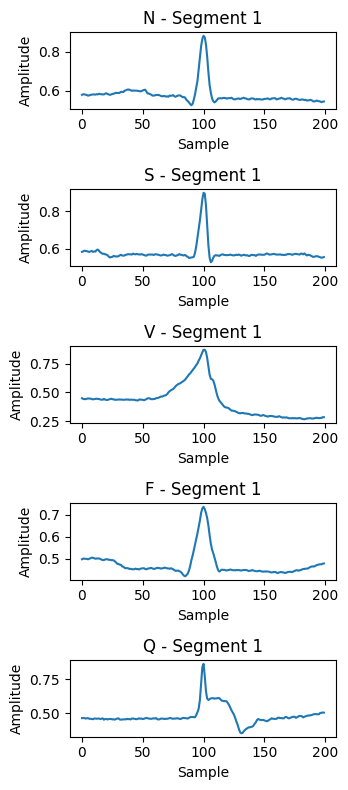

In [ ]:
# Define a dictionary to count the number of segments for each annotation type
num_segments_per_category = {}

# Create a single figure for all annotation types
plt.figure(figsize=(15, 8))

# Visualize each type of annotation
for i, (aami_label, segments) in enumerate(aami_categories.items()):
    num_segments = len(segments)
    num_segments_per_category[aami_label] = num_segments

    for j, segment in enumerate(segments[:1]):
        plt.subplot(5, len(aami_categories), i * 5 + j + 1)
        plt.plot(segment)
        plt.title(f'{aami_label} - Segment {j + 1}')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

# Print the number of segments for each annotation type
for aami_label, num_segments in num_segments_per_category.items():
    if(aami_label == 'S'):
        num_seg_s = num_segments
    elif(aami_label == 'F'):
        num_seg_f = num_segments
    elif(aami_label == 'N'):
        num_seg_n = num_segments
    elif(aami_label == 'V'):
        num_seg_v = num_segments
    elif(aami_label == 'Q'):
        num_seg_q = num_segments

    print(f'AAMI Class Type: {aami_label}, Number of Segments: {num_segments}')

In [ ]:
# Set the desired number of samples for S and F
desired_samples_S = 3*num_seg_s
desired_samples_F = 3*num_seg_f

# Create a dictionary with the desired number of samples for each class
sampling_strategy = {'F': desired_samples_F, 'S': desired_samples_S}

# Use RandomOverSampler to oversample the minority classes (F and S) in the entire dataset
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

# Fit and transform the dataset
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Check the number of samples for S and F after resampling
Total = num_seg_n + sum(y_resampled == 'S') + num_seg_v + num_seg_q + sum(y_resampled == 'F')

print("Total Number of samples after oversampling minority class:", Total)
print()
print("Number of samples for 'N' after oversampling minority class:", num_seg_n)
print("Number of samples for 'S' after oversampling minority class:", sum(y_resampled == 'S'))
print("Number of samples for 'V' after oversampling minority class:", num_seg_v)
print("Number of samples for 'F' after oversampling minority class:", sum(y_resampled == 'F'))
print("Number of samples for 'Q' after oversampling minority class:", num_seg_q)


Total Number of samples after oversampling minority class: 117331

Number of samples for 'N' after oversampling minority class: 95696
Number of samples for 'S' after oversampling minority class: 7458
Number of samples for 'V' after oversampling minority class: 8347
Number of samples for 'F' after oversampling minority class: 1536
Number of samples for 'Q' after oversampling minority class: 4294


In [ ]:
pip install imbalanced-learn

In [ ]:
df = pd.DataFrame(data=X_resampled, columns=[f'value{i}' for i in range(1, X_resampled.shape[1] + 1)])
df['label'] = y_resampled

# Save the entire dataset to a CSV file
df.to_csv('final_randomoversampling.csv', index=False)

In [ ]:
print("Total Number of samples after synthesizing minority class:", Total)
print()
print("Number of samples for 'N' after synthesizing minority class:", num_seg_n)
print("Number of samples for 'S' after synthesizing minority class:", sum(y_resampled == 'S'))
print("Number of samples for 'V' after synthesizing minority class:", num_seg_v)
print("Number of samples for 'F' after synthesizing minority class:", sum(y_resampled == 'F'))
print("Number of samples for 'Q' after synthesizing minority class:", num_seg_q)

Total Number of samples after synthesizing minority class: 117331

Number of samples for 'N' after synthesizing minority class: 95696
Number of samples for 'S' after synthesizing minority class: 7458
Number of samples for 'V' after synthesizing minority class: 8347
Number of samples for 'F' after synthesizing minority class: 1536
Number of samples for 'Q' after synthesizing minority class: 4294


In [ ]:
oversampler

RandomOverSampler(random_state=42, sampling_strategy={'F': 1536, 'S': 7458})

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming X and y are your feature and target variables

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Specify the desired ratio for each class
sampling_strategy = {'S': 3*num_seg_s, 'F': 3*num_seg_f}

# Instantiate the SMOTE class with specified sampling_strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and transform the training data
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

In [ ]:
df = pd.DataFrame(data=X_resampled_smote, columns=[f'value{i}' for i in range(1, X_resampled_smote.shape[1] + 1)])
df['label'] = y_resampled_smote

# Save the entire dataset to a CSV file
df.to_csv('final_smote.csv', index=False)

In [ ]:
smote

SMOTE(random_state=42, sampling_strategy={'F': 1536, 'S': 7458})

In [ ]:
len(X_resampled_smote)

84857

# **CNN - LSTM Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# hybrid CNN-LSTM model
model = models.Sequential()

# CNN layers
model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())

# Dense layer
model.add(layers.Dense(200, activation='relu'))

# Reshape data
model.add(layers.Reshape((200, 1)))

# LSTM layers
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))

# Dense layers
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))  # Adjust the number of output units based on your number of classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

history = model.fit(X_train_reshaped, y_train, epochs=10, validation_data=(X_val_reshaped, y_val))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 198, 32)           128       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 99, 32)            0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3168)              0         
                                                                 
 dense_9 (Dense)             (None, 200)               633800    
                                                                 
 reshape_3 (Reshape)         (None, 200, 1)            0         
                                                                 
 lstm_6 (LSTM)               (None, 200, 64)           16896     
                                                      

Epoch 1/10
2436/2436 [==============================] - 53s 19ms/step - loss: 0.5014 - accuracy: 0.8677 - val_loss: 0.3987 - val_accuracy: 0.8837
Epoch 2/10
2436/2436 [==============================] - 45s 18ms/step - loss: 0.3543 - accuracy: 0.8942 - val_loss: 0.3320 - val_accuracy: 0.8965
Epoch 3/10
2436/2436 [==============================] - 42s 17ms/step - loss: 0.3030 - accuracy: 0.9029 - val_loss: 0.3119 - val_accuracy: 0.8953
Epoch 4/10
2436/2436 [==============================] - 41s 17ms/step - loss: 0.2798 - accuracy: 0.9103 - val_loss: 0.2720 - val_accuracy: 0.9079
Epoch 5/10
2436/2436 [==============================] - 42s 17ms/step - loss: 0.2642 - accuracy: 0.9145 - val_loss: 0.2543 - val_accuracy: 0.9166
Epoch 6/10
2436/2436 [==============================] - 42s 17ms/step - loss: 0.2543 - accuracy: 0.9162 - val_loss: 0.2600 - val_accuracy: 0.9108
Epoch 7/10
2436/2436 [==============================] - 44s 18ms/step - loss: 0.2458 - accuracy: 0.9173 - val_loss: 0.2367 -

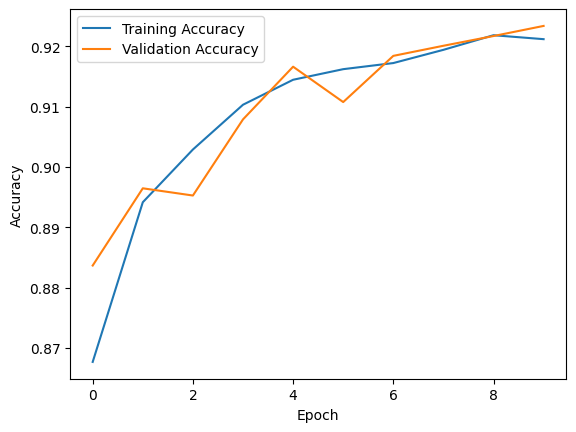

In [ ]:


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Plot the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
X_train_reshaped = X_train_reshaped.astype('float32')
X_val_reshaped = X_val_reshaped.astype('float32')
X_test_reshaped = X_test_reshaped.astype('float32')


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Combine all labels to fit the label encoder
all_labels = np.concatenate((y_train, y_val, y_test))

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
all_labels_encoded = label_encoder.fit_transform(all_labels)

# Split the encoded labels back to train, validation, and test sets
y_train_encoded = all_labels_encoded[:len(y_train)]
y_val_encoded = all_labels_encoded[len(y_train):(len(y_train) + len(y_val))]
y_test_encoded = all_labels_encoded[(len(y_train) + len(y_val)):]

# Convert the encoded labels to int32
y_train = y_train_encoded.astype('int32')
y_val = y_val_encoded.astype('int32')
y_test = y_test_encoded.astype('int32')


522/522 [==============================] - 13s 7ms/step
Validation Accuracy: 0.026047904191616768

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.02      0.70      0.04        73
           1       0.00      0.00      0.00     14345
           2       0.00      0.00      0.00       645
           3       0.03      0.97      0.05       396
           4       0.00      0.00      0.00      1241

    accuracy                           0.03     16700
   macro avg       0.01      0.33      0.02     16700
weighted avg       0.00      0.03      0.00     16700


Validation Confusion Matrix:
 [[   51     0     1    21     0]
 [ 1840     0     9 12496     0]
 [  494     0     0   151     0]
 [   12     0     0   384     0]
 [  393     0     0   848     0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


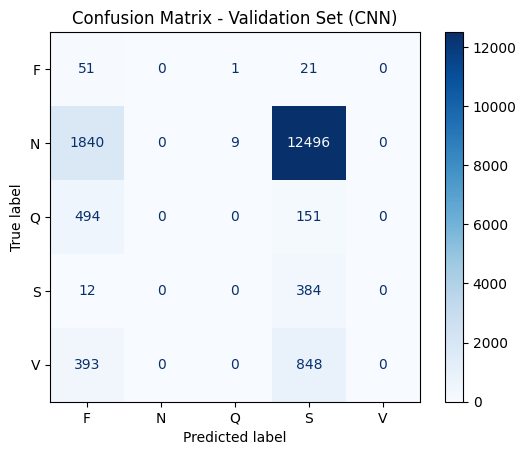

In [ ]:
# Assuming you have trained and compiled your CNN model
# model = ...

# Get predictions for the validation set
y_val_pred_prob = model.predict(X_val)

# Convert predicted probabilities to class labels
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

# Display result statistics for the validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Get unique class labels from your data
unique_labels = ['F', 'N', 'Q', 'S', 'V']

# Plot confusion matrix for the validation set
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, y_val_pred),
                               display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Validation Set (CNN)')
plt.show()



In [ ]:
# Predict on the test set
y_pred_probs = model.predict(X_test_reshaped)
y_pred_classes = tf.argmax(y_pred_probs, axis=1)

# Convert to numpy array
y_pred_classes = y_pred_classes.numpy()


522/522 [==============================] - 5s 8ms/step


In [ ]:
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)


522/522 [==============================] - 4s 8ms/step


In [ ]:
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nValidation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))


Validation Accuracy: 0.9234131736526946

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.34      0.43        73
           1       0.94      0.97      0.96     14345
           2       0.95      0.89      0.92       645
           3       0.63      0.40      0.49       396
           4       0.70      0.56      0.62      1241

    accuracy                           0.92     16700
   macro avg       0.76      0.64      0.69     16700
weighted avg       0.92      0.92      0.92     16700


Validation Confusion Matrix:
 [[   25    41     0     0     7]
 [   15 13961    27    93   249]
 [    0    37   577     0    31]
 [    0   222     3   160    11]
 [    2   538     1     2   698]]


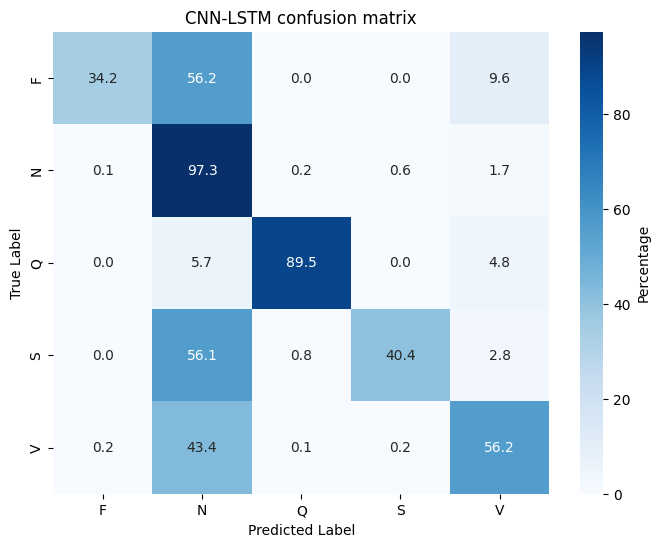

In [ ]:
cm_percentage = cm / cm.sum(axis=1)[:, np.newaxis] * 100

# Create a heatmap with percentages and a border around the entire plot
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels,
                 cbar_kws={'label': 'Percentage'})

# Add a border around the entire plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.title('CNN-LSTM confusion matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

522/522 [==============================] - 6s 11ms/step


<ipython-input-53-d741f14902c6>:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


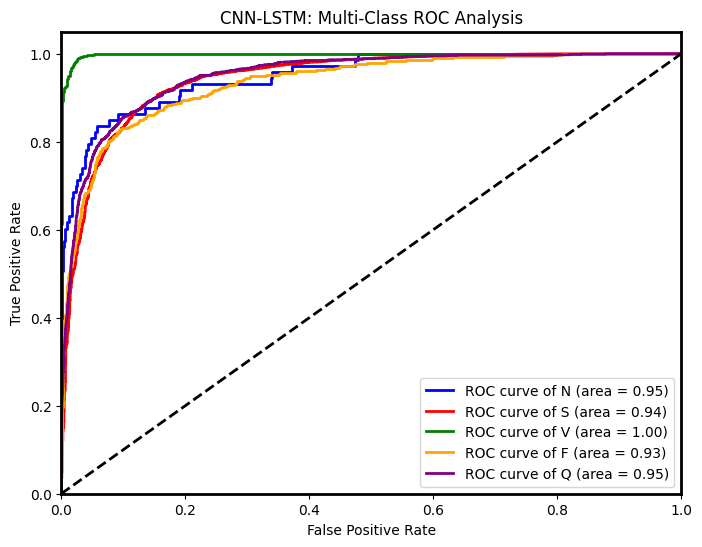

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from scipy import interp

# Assuming you have trained and compiled your CNN model
# model = ...

# Get predictions for the validation set
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

# Your true class labels (replace with your actual variable)
true_classes = y_val

# Your class labels (replace with your actual class labels)
class_labels = ['N', 'S', 'V', 'F', 'Q']  # Replace with your arrhythmia class labels

# Binarize the true classes for ROC curve calculation
y_test_binarized = label_binarize(true_classes, classes=np.arange(len(class_labels)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_val_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves with a border around the entire plot
plt.figure(figsize=(8, 6))
ax = plt.gca()

colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN-LSTM: Multi-Class ROC Analysis')

# Add a border around the entire plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.legend(loc="lower right")
plt.show()


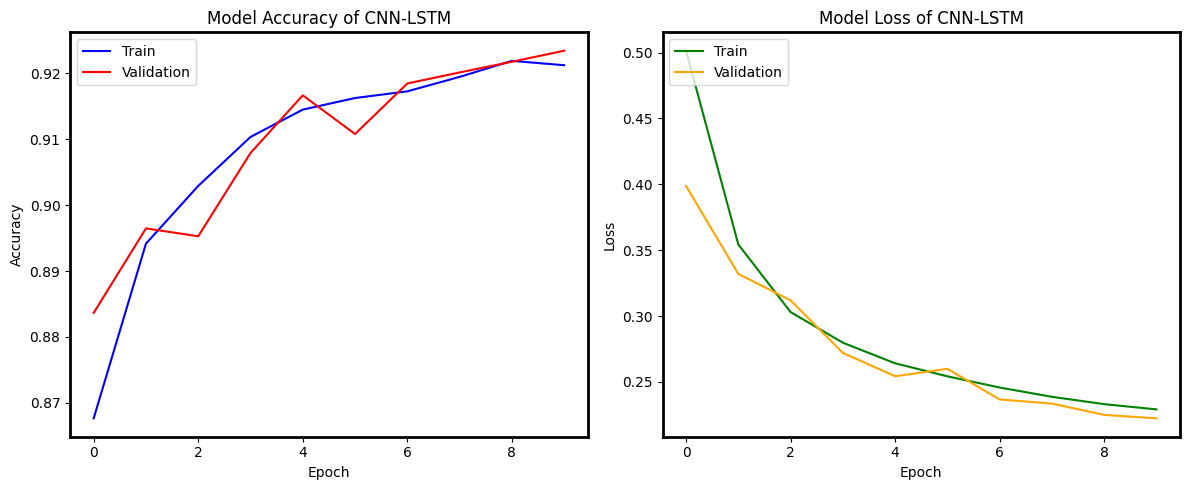

In [ ]:
# Plot training & validation accuracy values with a border around the entire plot
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['accuracy'], color='blue', label='Train')
ax1.plot(history.history['val_accuracy'], color='red', label='Validation')
ax1.set_title('Model Accuracy of CNN-LSTM')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

# Plot training & validation loss values with a border around the entire plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history['loss'], color='green', label='Train')
ax2.plot(history.history['val_loss'], color='orange', label='Validation')
ax2.set_title('Model Loss of CNN-LSTM')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')

# Add a border around the entire figure
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

plt.tight_layout()
plt.show()
